# Tanzanian Water Wells


## Problem Description

#### Load Packages and Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
# Load the predictor data

wells = pd.read_csv('training_set_values.csv')
wells.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
# Load the target data

target = pd.read_csv('training_set_labels.csv')

target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## 1. Exploratory Data Analysis

Get a sense of the big picture for the dataset. Prepare the data for further analysis. Gain an understanding of the variables, or predictors in this case. Study the relationship between variables. Make plan for initial model. 

In [4]:
print("Records for wells:", wells.shape)
print()
print("Records for target:", target.shape)

Records for wells: (59400, 40)

Records for target: (59400, 2)


In [5]:
# Identify datatypes and record amount for each predictor

wells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
# Examine numerical predictors mean, min, max

wells.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [7]:
# Missing data total
wells.isna().sum().sum()

46094

In [8]:
# Missing data by predictor

wells.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [9]:
# Data missing for target
target.isna().sum()

id              0
status_group    0
dtype: int64

In [10]:
# Examine value counts for the target, consider imbalance in target data
target['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [11]:
# Percentage makeup of target values
print("Functional percentage:", round(32259/59400*100, 2))
print("Non functional percentage:", round(22824/59400*100, 2))
print("Functional needs repair percentage:", round(4317/59400*100, 2))

Functional percentage: 54.31
Non functional percentage: 38.42
Functional needs repair percentage: 7.27


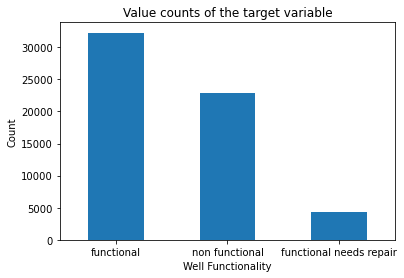

In [12]:
target.status_group.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Well Functionality")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

In [13]:
# Identify unique values per column
print(wells.nunique())

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

AxesSubplot(0.125,0.125;0.775x0.755)


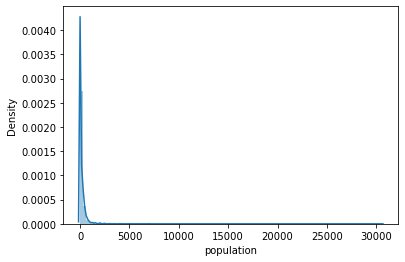

In [14]:
# Check distribution for numeric data
import warnings
warnings.filterwarnings('ignore')

print(sns.distplot(wells.population, bins = 100))



<AxesSubplot:xlabel='population'>

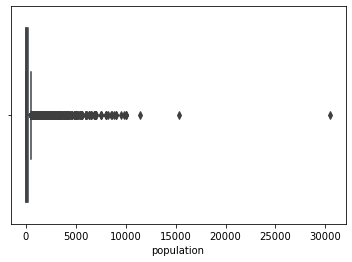

In [68]:
sns.boxplot(wells.population)


In [71]:
print(wells.population.value_counts())
print(wells.population.nunique())

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64
1049


count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64


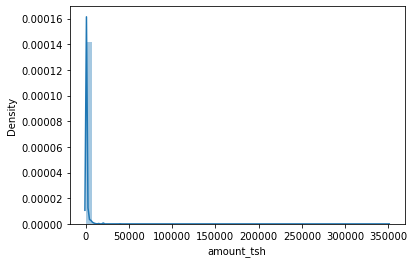

In [79]:
sns.distplot(wells.amount_tsh)

print(wells.amount_tsh.describe())


<AxesSubplot:xlabel='amount_tsh'>

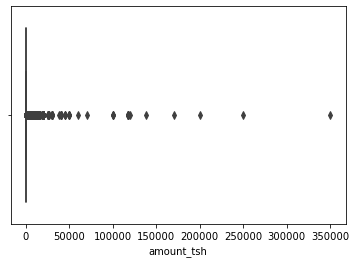

In [17]:
sns.boxplot(wells.amount_tsh)

In [64]:
print(wells.amount_tsh.value_counts())

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64


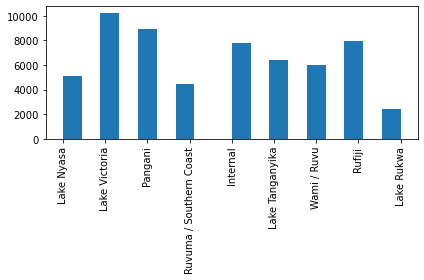

In [77]:
# plot basins
fig, axs = plt.subplots(1, 1,
                        figsize =(6, 4),
                        tight_layout = True)
 
axs.hist(wells.basin, bins = 18)
plt.xticks(rotation = 90)

plt.show()

In [19]:
wells.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [20]:
wells.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [21]:
wells.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [22]:
wells.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [23]:
wells.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [24]:
wells.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [25]:
wells.scheme_name.value_counts()

K                             682
None                          644
Borehole                      546
Chalinze wate                 405
M                             400
                             ... 
Moroga                          1
Chikombo water supply           1
Kifunikoni water supply         1
Marua mshatie water supply      1
Tiflo masaki branch line        1
Name: scheme_name, Length: 2696, dtype: int64

In [26]:
wells.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [27]:
wells.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [28]:
wells.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [29]:
wells.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [30]:
wells.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Wirara Ya Maji               1
Lc                           1
Kagera                       1
Jacobin                      1
Matogoro                     1
Name: funder, Length: 1897, dtype: int64

In [31]:
wells.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [32]:
wells.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [33]:
wells.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [34]:
wells.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [35]:
wells.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [36]:
wells.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [37]:
wells.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [38]:
wells.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [39]:
wells.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [40]:
wells.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [41]:
wells.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [42]:
wells.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [43]:
wells.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [61]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(wells[1000:1020])

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type_group
1000,250.0,Oxfam,1409,OXFAM,30.105401,-4.367134,0,Lake Tanganyika,16,2,Kasulu,Munyegera,620,True,True,1996,gravity,gravity,water board,user-group,pay monthly,soft,enough,river,surface,communal standpipe
1001,0.0,Resolute Mining,0,Consulting Engineer,33.210098,-4.049685,0,Internal,14,1,Nzega,Lusu,0,False,False,0,afridev,handpump,vwc,user-group,never pay,salty,enough,machine dbh,groundwater,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,0.0,Government Of Tanzania,1307,DWE,38.325050,-4.464609,0,Pangani,4,1,Lushoto,Mbaramo,1,True,True,1985,gravity,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe
1019,0.0,Bulyahunlu Gold Mine,0,Bulyahunlu Gold Mine,32.370100,-3.281536,0,Lake Tanganyika,17,3,Kahama,Bugarama,0,True,True,0,other,other,vwc,user-group,unknown,milky,enough,shallow well,groundwater,other


## 2. Preprocess the data

Drop redundant columns. Drop columns that do not contribute to the model. Make plan for missing categorical and numeric data.

In [45]:
wells.drop(columns = ['id', 'date_recorded', 'wpt_name', 'region', 'recorded_by', 'scheme_name', 
           'scheme_management', 'extraction_type_group', 'payment_type', 'subvillage',
           'quality_group', 'quantity_group', 'source_type', 'waterpoint_type'], inplace = True)


In [46]:
wells.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'basin', 'region_code', 'district_code',
       'lga', 'ward', 'population', 'public_meeting', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type_group'],
      dtype='object')

In [47]:
# Check missing data
wells.isna().sum()

amount_tsh                  0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
num_private                 0
basin                       0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment                     0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
dtype: int64

In [62]:
# Replace Nan in public_meeting and permit as False

wells['public_meeting'] = wells['public_meeting'].fillna('False').astype('bool')
wells.public_meeting.head()

0    True
1    True
2    True
3    True
4    True
Name: public_meeting, dtype: bool

In [49]:
wells['permit'] = wells['permit'].fillna('False').astype('bool')
wells.permit.head()

0    False
1     True
2     True
3     True
4     True
Name: permit, dtype: bool

In [81]:
# create new boolean data type column for amount_tsh: 0.0 = False, if value = True

wells['static_head'] = wells['amount_tsh']

wells.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region_code,district_code,...,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type_group,static_head
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,11,5,...,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe,6000.0
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,20,2,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,0.0
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,0,Pangani,21,4,...,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe,25.0
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,90,63,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe,0.0
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,0,Lake Victoria,18,1,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,0.0


In [82]:
#df["gender"] = np.where(df["gender"] == "female", 0, 1)

wells['static_head'] = np.where(wells['static_head'] == 0.0, 0, 1)

wells['static_head'].value_counts()

0    41639
1    17761
Name: static_head, dtype: int64

## 3. Build initial model

In [83]:
# Assign the predictors and target
X = wells
y = target['status_group']

In [84]:
# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [85]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'basin', 'region_code', 'district_code',
       'lga', 'ward', 'population', 'public_meeting', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type_group',
       'static_head'],
      dtype='object')

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44550 entries, 24947 to 56422
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             44550 non-null  float64
 1   funder                 41859 non-null  object 
 2   gps_height             44550 non-null  int64  
 3   installer              41850 non-null  object 
 4   longitude              44550 non-null  float64
 5   latitude               44550 non-null  float64
 6   num_private            44550 non-null  int64  
 7   basin                  44550 non-null  object 
 8   region_code            44550 non-null  int64  
 9   district_code          44550 non-null  int64  
 10  lga                    44550 non-null  object 
 11  ward                   44550 non-null  object 
 12  population             44550 non-null  int64  
 13  public_meeting         44550 non-null  bool   
 14  permit                 44550 non-null  bool   
 15

In [87]:


# create subpipe for numeric data

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])

# create subpipe for categorical data, use SimpleImputer for 'missing' data.

subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant', fill_value = 'missing')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# combine subpipes into ColumnTransformer

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0, 2, 4, 5, 12]),
                                    ('subpipe_cat', subpipe_cat, [1, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16,
                                                                      17, 18, 19, 20, 21, 22, 23,
                                                                      24, 25, 26])],
                           remainder='passthrough')



In [88]:
# Use a decision tree for the initial model
from sklearn.tree import DecisionTreeClassifier
    
dtc_pipe = Pipeline(steps=[('ct', CT),
                            ('dtc', DecisionTreeClassifier(random_state=42))])

In [89]:
dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                             

In [90]:
dtc_pipe.score(X_train, y_train)

0.9983389450056117

In [91]:
y_hat = dtc_pipe.predict(X_test)

In [92]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      8098
functional needs repair       0.38      0.38      0.38      1074
         non functional       0.77      0.77      0.77      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.65      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



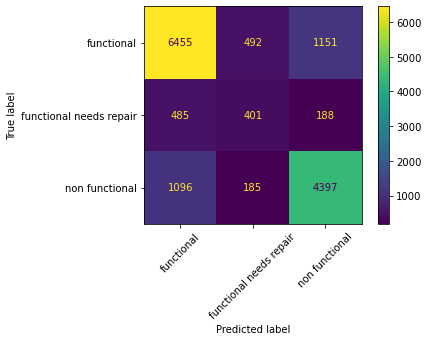

In [60]:
plot_confusion_matrix(dtc_pipe, X_test, y_test, xticks_rotation=45);